In [1]:
import json
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect, DetectorFactory
from tqdm import tqdm

# ----------------------------------------------------------------
# 0. CONFIG
# ----------------------------------------------------------------
DATA_PATH   = Path("data/dc.jsonl")   # <-- set your filename here
SAVE_PLOTS  = True                    # set False to skip file output
PLOT_DIR    = Path("eda_plots")
PLOT_DIR.mkdir(exist_ok=True)

DetectorFactory.seed = 0  # make langdetect deterministic




Loaded 4,659 turns from 966 conversations.

Conversation-level summary:
count    966.000000
mean       4.822981
std        0.720341
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: n_turns, dtype: float64


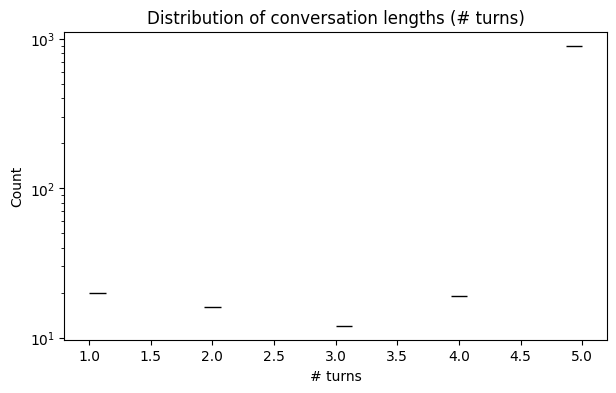

In [3]:

# ----------------------------------------------------------------
# 1. LOAD & FLATTEN
# ----------------------------------------------------------------
def load_dataset(path: Path) -> pd.DataFrame:
    records = []
    with path.open(mode="r", encoding="utf-8", errors="replace") as f:
        for line in f:
            raw = json.loads(line)
            flat = {
                "conversation_id": raw.get("conversation_id"),
                "turn_idx"      : raw.get("turn_idx"),
                "student_msg"   : raw.get("student", ""),
            }
            # tutor_AT and tutor_AS have identical sub-keys; we keep both
            for ch in ("tutor_AT", "tutor_AS"):
                if ch in raw and isinstance(raw[ch], dict):
                    for k, v in raw[ch].items():
                        flat[f"{ch}_{k}"] = v
            records.append(flat)
    return pd.DataFrame(records)

df = load_dataset(DATA_PATH)
print(f"\nLoaded {len(df):,} turns from {df['conversation_id'].nunique():,} conversations.")

# ----------------------------------------------------------------
# 2. BASIC CONVERSATION-LEVEL STATS
# ----------------------------------------------------------------
conv_stats = (
    df.groupby("conversation_id")["turn_idx"]
      .agg(["count", "min", "max"])
      .rename(columns={"count": "n_turns"})
)
print("\nConversation-level summary:")
print(conv_stats["n_turns"].describe())

plt.figure(figsize=(7,4))
sns.histplot(conv_stats["n_turns"], bins=30, log_scale=(False, True))
plt.title("Distribution of conversation lengths (# turns)")
plt.xlabel("# turns"); plt.ylabel("Count")
if SAVE_PLOTS: plt.savefig(PLOT_DIR/"turn_count_hist.png", dpi=150, bbox_inches="tight")
plt.show()


In [5]:

# ----------------------------------------------------------------
# 3. LENGTH & TOKEN COUNTS
# ----------------------------------------------------------------
def char_count(text):
    return len(text)

df["student_chars"] = df["student_msg"].apply(char_count)
df["tutor_AT_chars"] = df["tutor_AT_Tutorbot"].str.len()
df["tutor_AS_chars"] = df["tutor_AS_Tutorbot"].str.len()

print("\nAverage char length:")
for col in ("student_chars", "tutor_AT_chars", "tutor_AS_chars"):
    print(f"  {col:<17}: {df[col].dropna().mean():6.1f}")



Average char length:
  student_chars    :  138.6
  tutor_AT_chars   :  333.2
  tutor_AS_chars   :  332.0



tutor_AT – distribución de 'Eval of Student Response':
tutor_AT_Eval of Student Response
a    2040
b    1567
c    1016
f      34
d       2
Name: count, dtype: int64


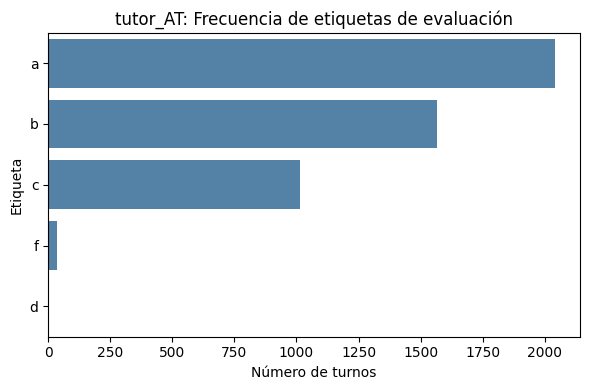


tutor_AS – distribución de 'Eval of Student Response':
tutor_AS_Eval of Student Response
a    1960
b    1581
c    1077
f      37
d       3
g       1
Name: count, dtype: int64


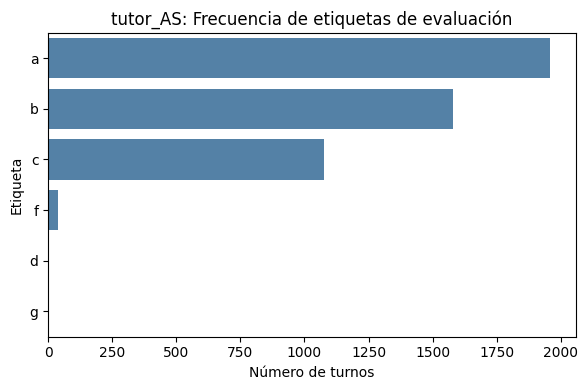

In [6]:
# ----------------------------------------------------------------
# 4. LABEL DISTRIBUTIONS  (bloque corregido)
# ----------------------------------------------------------------
for ch in ("tutor_AT", "tutor_AS"):
    col = f"{ch}_Eval of Student Response"
    if col not in df.columns:
        continue

    label_counts = df[col].value_counts(dropna=True)

    print(f"\n{ch} – distribución de 'Eval of Student Response':\n{label_counts}")

    # Convertimos a DataFrame para que seaborn esté contento
    lc_df = label_counts.reset_index()
    lc_df.columns = ["eval_label", "count"]

    plt.figure(figsize=(6, 4))
    sns.barplot(data=lc_df, x="count", y="eval_label", orient="h", color="steelblue")
    plt.title(f"{ch}: Frecuencia de etiquetas de evaluación")
    plt.xlabel("Número de turnos"); plt.ylabel("Etiqueta")
    plt.tight_layout()
    if SAVE_PLOTS:
        plt.savefig(PLOT_DIR / f"{ch}_eval_dist.png", dpi=150, bbox_inches="tight")
    plt.show()



Detecting language of student messages (this might take a few seconds)...

Student message language distribution:
student_lang
es    4565
en      33
ca      28
pt      25
so       2
fr       2
ro       2
it       1
cy       1
Name: count, dtype: int64


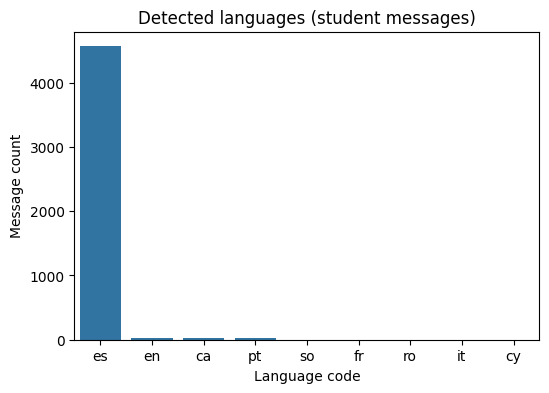


Top values for tutor_AT_Subproblem:
tutor_AT_Subproblem
Problema principal resuelto                                       25
Confirmación de la solución.                                      13
Establecer ecuaciones basadas en la información proporcionada.     7
Confirmación de la solución final                                  6
Formulación de la ecuación                                         5
Calcular el número de muñecas que tiene la hermana de Olivia.      5
Cálculo del trabajo total                                          4
Confirmación del plan de solución                                  4
Calcular el número de libros que tiene Olivia.                     4
Calcular el número de libros que tiene Samantha.                   4
Name: count, dtype: int64

Top values for tutor_AT_Subproblem State:
tutor_AT_Subproblem State
x    2361
y    1255
w     988
z      55
Name: count, dtype: int64

Core numeric summary saved to eda_core_stats.csv

EDA complete ✔


In [7]:
# ----------------------------------------------------------------
# 5. LANGUAGE DETECTION (student messages)
# ----------------------------------------------------------------
print("\nDetecting language of student messages (this might take a few seconds)...")
df["student_lang"] = df["student_msg"].apply(
    lambda txt: detect(txt) if isinstance(txt, str) and txt.strip() else "unknown"
)

lang_counts = df["student_lang"].value_counts()
print("\nStudent message language distribution:")
print(lang_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=lang_counts.index, y=lang_counts.values)
plt.title("Detected languages (student messages)")
plt.ylabel("Message count"); plt.xlabel("Language code")
if SAVE_PLOTS: plt.savefig(PLOT_DIR/"lang_dist.png", dpi=150, bbox_inches="tight")
plt.show()

# ----------------------------------------------------------------
# 6. TOP SUBPROBLEMS & STATES
# ----------------------------------------------------------------
for field in ("tutor_AT_Subproblem", "tutor_AT_Subproblem State"):
    if field in df.columns:
        top = df[field].value_counts().head(10)
        print(f"\nTop values for {field}:")
        print(top)

# ----------------------------------------------------------------
# 7. SAVE CORE NUMERIC SUMMARY TO CSV
# ----------------------------------------------------------------
summary = {
    "n_turns_total"           : len(df),
    "n_conversations"         : df["conversation_id"].nunique(),
    "mean_turns_per_conv"     : conv_stats["n_turns"].mean(),
    "median_turns_per_conv"   : conv_stats["n_turns"].median(),
    "mean_student_chars"      : df["student_chars"].mean(),
    "mean_tutor_AT_chars"     : df["tutor_AT_chars"].mean(),
    "mean_tutor_AS_chars"     : df["tutor_AS_chars"].mean(),
}
pd.Series(summary, name="EDA_stats").to_csv("eda_core_stats.csv")
print("\nCore numeric summary saved to eda_core_stats.csv")

# ----------------------------------------------------------------
print("\nEDA complete ✔")
